In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
import numpy as np
import pandas as pd
import pyBigWig
import pyranges as pr
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import scipy


# get last pa sites
# get single polya site gene
last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])


# load data

In [3]:
%store -r cb_pool_read_through_len

In [4]:
all_gene = set(cb_pool_read_through_len['gene_id'])

# main function

In [5]:
# load TSS
tss_bed = '/public/home/mowp/data/public_data/epigentics_data/cage_seq_2020/major_TSS.bed'
tss_bed = pr.read_bed(tss_bed, as_df=True)
tss_bed = tss_bed.set_index(['Name'])

# For bw file
def get_target_site(site_type: str, gene_id: str) -> int:
    if site_type == 'PAS':
        # polya site
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        try:
            values = tss_bed.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
        except KeyError:
            values = gene_model.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
    
    elif site_type == 'aTSS':
        # araport11注释的TSS
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[1]
        else:
            return values[2]
        
    elif site_type == 'TWE':
        # 获取3' end of uncleaved readthrough
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        return int(cb_pool_read_through_len.query('gene_id == @gene_id')['tts'])
            
    elif site_type == 'aTES':
        # araport11注释的TES
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
    else:
        raise KeyError

In [6]:
def get_bin_cov(methyratio: list, bins: int, threshold=4):
    methyratio = np.array(methyratio)
    results = []
    for i in range(0, len(methyratio), bins):
        bin_methyratio = methyratio[i:i + bins]
        if len(bin_methyratio[~np.isnan(bin_methyratio)]) >= threshold:
            # we selected for bins with at least 4 cytosines
            # that are each covered by at least 4 reads
            mean_methyratio = np.nanmean(bin_methyratio)
        else:
            mean_methyratio = np.nan
        results.append(mean_methyratio)

    return results

## site-point

In [7]:
def get_cov(infile: str, gene_id: str, site: str,
            before: int, after: int, bins: int,
            chrom_prefix: str):
    '''
    计算甲基化水平覆盖度
    '''
    try:
        chrom, start, end, _, strand = gene_model.loc[gene_id]
    except KeyError:
        return

    if chrom in {'Pt', 'Mt', 'chrM', 'chrC'}:
        return None
    chrom = chrom_prefix + chrom

    target_site = get_target_site(site, gene_id)  # site1
    if target_site is None:
        return
    
    bwfile = pyBigWig.open(infile)
    try:
        if strand == '+':
            methyratio = bwfile.values(chrom, 
                                       target_site - before,
                                       target_site + after)
            cov = get_bin_cov(methyratio, bins)

        else:
            methyratio = bwfile.values(chrom, 
                                       target_site - after,
                                       target_site + before)[::-1]
            cov = get_bin_cov(methyratio, bins)

    except RuntimeError:
        return

    return cov, gene_id

In [8]:
def get_meta_result(infile,
                    gene_list,
                    site,
                    before=1000,
                    after=1000,
                    bins=100,
                    chrom_prefix='',
                    threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list) / threads)
        results = e.map(get_cov,
                        repeat(infile),
                        gene_list,
                        repeat(site),
                        repeat(before),
                        repeat(after),
                        repeat(bins),
                        repeat(chrom_prefix),
                        chunksize=chunksize)

    cov = []
    for res in results:
        if res is not None:
            cov_, gene_id = res
            cov.append(cov_)
    
    cov = np.nanmean(cov, axis=0)
    return cov

In [9]:
def set_ax(ax, b1, a1, b2, a2, bins, site1='TSS', site2='TES', ylabel=None):
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].set_ylabel(ylabel)

    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].yaxis.set_ticks_position('none')

    ax[0].set_xticks([0, b1//bins, (a1+b1)//bins])
    ax[0].set_xticklabels([f'-{b1//1000} kb', site1, f'{a1//1000} kb'], rotation=90)

    ax[1].set_xticks([0, b2//bins, (a2+b2)//bins])
    ax[1].set_xticklabels([f'-{b2//1000} kb', site2, f'{a2//1000} kb'], rotation=90)

    ax[0].axvline(b1//bins, ls='--', color='#555555')
    ax[1].axvline(b2//bins, ls='--', color='#555555')

## reference-scale

In [10]:
def get_scale_cov(infile: str, gene_id: str, site1: str, site2: str,
                  before: int, after: int, regionbody: int, bins: int,
                  chrom_prefix: str):
    '''
    计算甲基化水平覆盖度
    '''
    chrom, start, end, _, strand = gene_model.loc[gene_id]

    if end - start < bins:
        return

    if chrom in {'Pt', 'Mt', 'chrM', 'chrC'}:
        return None
    chrom = chrom_prefix + chrom

    site1 = get_target_site(site1, gene_id)  # site1
    site2 = get_target_site(site2, gene_id)  # site1

    bwfile = pyBigWig.open(infile)
    try:
        if strand == '+':
            methyratio_5 = bwfile.values(chrom, site1 - before, site1)
            cov_5 = get_bin_cov(methyratio_5, bins)
            methyratio_3 = bwfile.values(chrom, site2, site2 + after)
            cov_3 = get_bin_cov(methyratio_3, bins)

            # gene_body_region
            methyratio_gb = bwfile.values(chrom, site1, site2)
            methyratio_gb = scipy.ndimage.zoom(methyratio_gb,
                                               regionbody / len(methyratio_gb),
                                               order=0,
                                               mode='nearest')
            cov_gb = get_bin_cov(methyratio_gb, bins)

        else:
            methyratio_5 = bwfile.values(chrom, site2 + before, site1)[::-1]
            cov_5 = get_bin_cov(methyratio_5, bins)
            methyratio_3 = bwfile.values(chrom, site2, site2 - after)[::-1]
            cov_3 = get_bin_cov(methyratio_3, bins)

            # gene_body_region
            methyratio_gb = bwfile.values(chrom, site1, site2)[::-1]
            methyratio_gb = scipy.ndimage.zoom(methyratio_gb,
                                               regionbody / len(methyratio_gb),
                                               order=0,
                                               mode='nearest')
            cov_gb = get_bin_cov(methyratio_gb, bins)

    except RuntimeError:
        return
    
    cov = np.concatenate([cov_5, cov_gb, cov_3])

    return cov, gene_id

In [11]:
def get_meta_scale_result(infile,
                          gene_list,
                          site1,
                          site2,
                          before=1000,
                          after=1000,
                          regionbody=1000,
                          bins=100,
                          chrom_prefix='',
                          threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list) / threads)
        results = e.map(get_scale_cov,
                        repeat(infile),
                        gene_list,
                        repeat(site1),
                        repeat(site2),
                        repeat(before),
                        repeat(after),
                        repeat(regionbody),
                        repeat(bins),
                        repeat(chrom_prefix),
                        chunksize=chunksize)

    cov = []
    for res in results:
        if res is not None:
            cov_, gene_id = res
            cov.append(cov_)

    cov = np.nanmean(cov, axis=0)
    return cov

# CG methylation

## site-point

In [12]:
infile = '/public/home/mowp/test/BS_Seq/bw_files/WT_BS_GSM1242401.methratio.cg.bw'
bins = 50
b1 = 1000
a1 = 1000
tts_cov = get_meta_result(infile, all_gene, 'PAS', bins=bins, before=b1, after=a1)

b2 = 1000
a2 = 1000
pas_cov = get_meta_result(infile, all_gene, 'TWE', bins=bins, before=b2, after=a2)

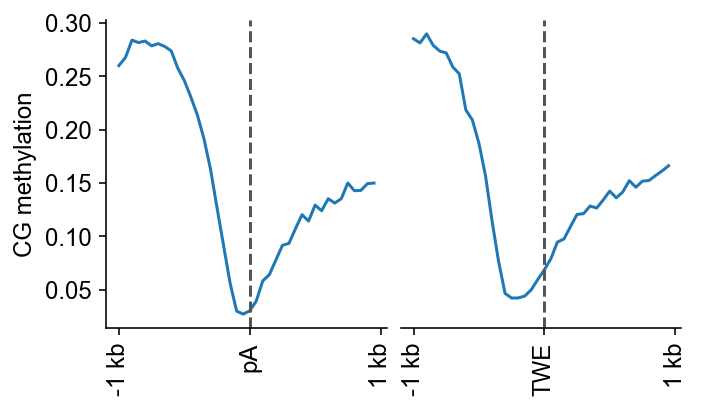

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
ax[0].plot(tts_cov)
ax[1].plot(pas_cov)

set_ax(ax, b1, a1, b2, a2, bins, site1='pA', site2='TWE', ylabel='CG methylation')

plt.tight_layout()
plt.subplots_adjust(wspace=.05);

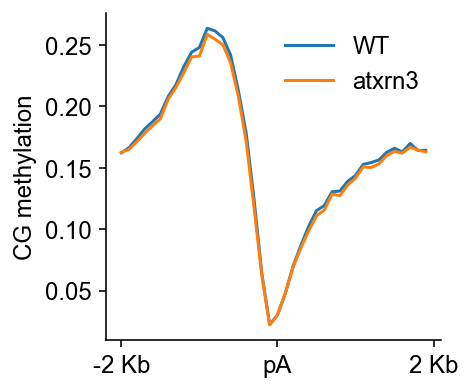

In [14]:
bins = 100
b1 = 2000
a1 = 2000

fig, ax = plt.subplots(1, figsize=(3, 3))
# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, all_gene, 'PAS', bins=bins, before=b1, after=a1)
plt.plot(cov, label='WT')

#2
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, all_gene, 'PAS', bins=bins, before=b1, after=a1)
plt.plot(cov, label='atxrn3')

ax = plt.gca()
ax.set_xticks([0, b1//bins, (a1+b1)//bins])
ax.set_xticklabels(['-2 Kb', 'pA', '2 Kb'])
ax.patch.set_visible(False)

plt.ylabel('CG methylation')
plt.legend(frameon=False)

sns.despine(top=True, right=True)

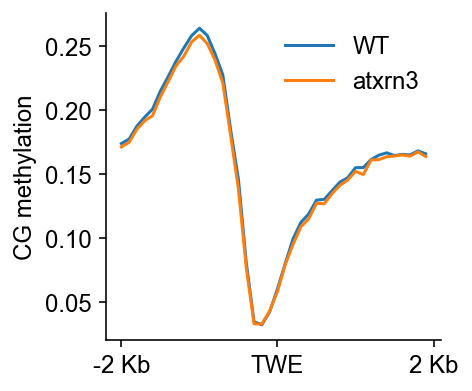

In [15]:
bins = 100
b1 = 2000
a1 = 2000

fig, ax = plt.subplots(1, figsize=(3, 3))
# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, all_gene, 'TWE', bins=bins, before=b1, after=a1)
plt.plot(cov, label='WT')

#2
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, all_gene, 'TWE', bins=bins, before=b1, after=a1)
plt.plot(cov, label='atxrn3')

ax = plt.gca()
ax.set_xticks([0, b1//bins, (a1+b1)//bins])
ax.set_xticklabels(['-2 Kb', 'TWE', '2 Kb'])
ax.patch.set_visible(False)

plt.ylabel('CG methylation')
plt.legend(frameon=False)

sns.despine(top=True, right=True)

## reference-scale

### atxrn3

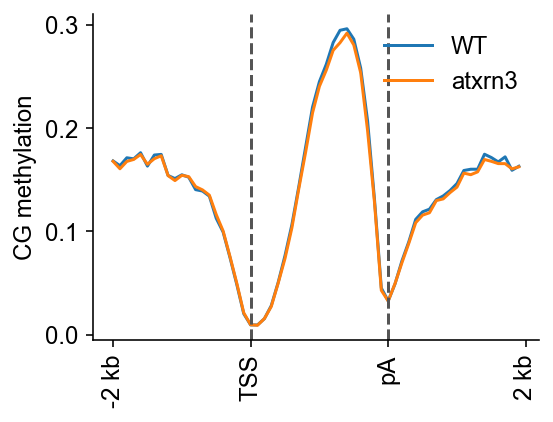

In [17]:
plt.figure(figsize=(4, 3))

bins = 100
b = 2000
a = 2000
m = 2000

# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.cg.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='WT')

#2
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.cg.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='atxrn3')

plt.xticks([0, b//bins, (b+m)//bins, (a+b+m)//bins], [f'-{b//1000} kb', 'TSS', 'pA', f'{a//1000} kb'], rotation=90)
plt.axvline(b//bins, ls='--', color='#555555')
plt.axvline((b+m)//bins, ls='--', color='#555555')

plt.ylabel('CG methylation')
plt.legend(frameon=False)

sns.despine(top=True, right=True)

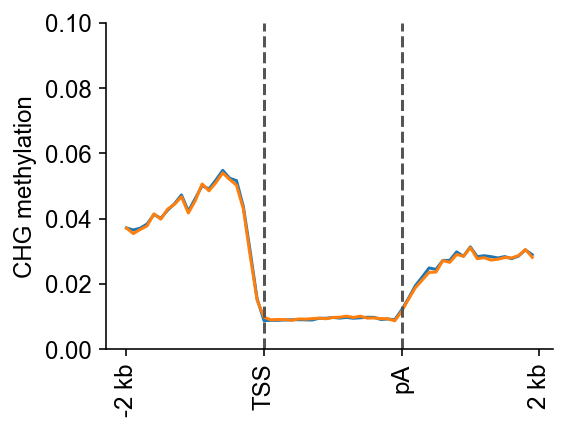

In [ ]:
plt.figure(figsize=(4, 3))

# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.chg.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='WT')

#2
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.chg.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='xrn3')

plt.xticks([0, b//bins, (b+m)//bins, (a+b+m)//bins], [f'-{b//1000} kb', 'TSS', 'pA', f'{a//1000} kb'], rotation=90)
plt.axvline(b//bins, ls='--', color='#555555')
plt.axvline((b+m)//bins, ls='--', color='#555555')

plt.ylabel('CHG methylation')
# plt.legend(frameon=False)
plt.ylim(0, 0.1)

sns.despine(top=True, right=True)

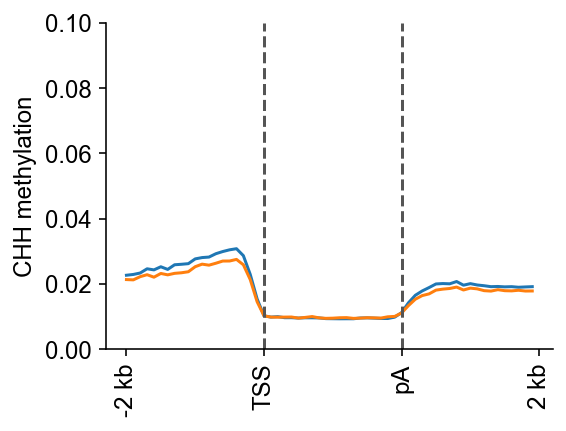

In [ ]:
plt.figure(figsize=(4, 3))

# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.chh.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='WT')

#2
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.chh.bw'
cov = get_meta_scale_result(infile, all_gene, 'aTSS', 'PAS', bins=bins, before=b, after=a, regionbody=m)
plt.plot(cov, label='xrn3')

plt.xticks([0, b//bins, (b+m)//bins, (a+b+m)//bins], [f'-{b//1000} kb', 'TSS', 'pA', f'{a//1000} kb'], rotation=90)
plt.axvline(b//bins, ls='--', color='#555555')
plt.axvline((b+m)//bins, ls='--', color='#555555')

plt.ylabel('CHH methylation')
# plt.legend(frameon=False)
plt.ylim(0, 0.1)

sns.despine(top=True, right=True)

## APA

In [114]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.major_polya_cluster_summit.bed'
major_pa = pr.read_bed(infile, as_df=True)
major_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
major_pa.loc[:, 'Chromosome'] = major_pa.loc[:, 'Chromosome'].astype('str')
major_pa['gene_id'] = major_pa['Name'].map(lambda x: x.split('_')[0])
major_pa.set_index(['gene_id'], inplace=True)

In [115]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.polya_cluster.summit.bed'
all_pa = pr.read_bed(infile, as_df=True)
all_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
all_pa.loc[:, 'Chromosome'] = all_pa.loc[:, 'Chromosome'].astype('str')
all_pa['gene_id'] = all_pa['Name'].map(lambda x: x.split('_')[0])
# all_pa.set_index(['gene_id'], inplace=True)

In [116]:
major_pa_list = list(major_pa['Name'])

In [117]:
a_pa = all_pa.query('Name not in @major_pa_list').copy()
a_pa['gene_id'] = a_pa['Name'].map(lambda x: x.split('_')[0])
a_pa.set_index(['gene_id'], inplace=True)

In [86]:
# For bw file
def get_target_site(site_type: str, gene_id: str) -> int:
    try:
        if site_type == 'major':
            return major_pa.at[gene_id, 'End']
        elif site_type == 'apa':
            return a_pa.at[gene_id, 'End']
    except KeyError:
        return

In [122]:
apa_gene_list = list(a_pa.index)

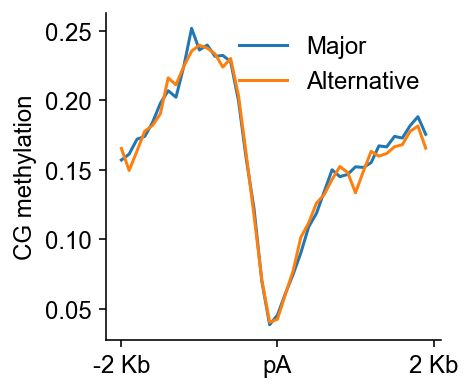

In [123]:
bins = 100
b1 = 2000
a1 = 2000


fig, ax = plt.subplots(1, figsize=(3, 3))
# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/col0_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, apa_gene_list, 'major', bins=bins, before=b1, after=a1)
plt.plot(cov, label='Major')

#2
gene_list = list(a_pa.index)
cov = get_meta_result(infile, apa_gene_list, 'apa', bins=bins, before=b1, after=a1)
plt.plot(cov, label='Alternative')

ax = plt.gca()
ax.set_xticks([0, b1//bins, (a1+b1)//bins])
ax.set_xticklabels(['-2 Kb', 'pA', '2 Kb'])
ax.patch.set_visible(False)

plt.ylabel('CG methylation')
plt.legend(frameon=False)

sns.despine(top=True, right=True)

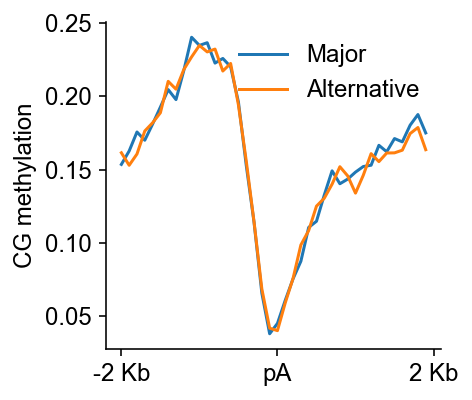

In [124]:
bins = 100
b1 = 2000
a1 = 2000


fig, ax = plt.subplots(1, figsize=(3, 3))
# 1
infile = '/public/home/mowp/data/bs_seq/20210908_bs_seq_xrn3/bw_files/xrn3_wgbs.methratio.cg.bw'
cov = get_meta_result(infile, apa_gene_list, 'major', bins=bins, before=b1, after=a1)
plt.plot(cov, label='Major')

#2
gene_list = list(a_pa.index)
cov = get_meta_result(infile, apa_gene_list, 'apa', bins=bins, before=b1, after=a1)
plt.plot(cov, label='Alternative')

ax = plt.gca()
ax.set_xticks([0, b1//bins, (a1+b1)//bins])
ax.set_xticklabels(['-2 Kb', 'pA', '2 Kb'])
ax.patch.set_visible(False)

plt.ylabel('CG methylation')
plt.legend(frameon=False)

sns.despine(top=True, right=True)